# Clustering the Brazilian Biggest Cities

## Table of Contents

 1. Introduction 
 2. Methodology
 3. Results
 4. Discussion
 5. Conclusion and future directions

## 1 - Introduction 

### About the problem

#### Brazil has a population of more than 200 million people. And also, it has a very large territory and a very diverse population. Then, the Brazilian cities has many differences among them. Knowing this differences and the similarities its a very important issue and can give a more complete picture of the country, revealing  insights that could be hidden. 

#### Therefore, we are going to use the k-means clusterization method to group the biggest Brazilian cities according to their demographic information and their most common venues, this way we are looking at both, the demographics and a representative picture of the economic activities of each city.  The insights given by knowing this clusters could be used by the Cities Governments or NGOs in order to make benchmarks and be aware about public politics of similar cities, which probably faces similar problems. And also, can be used by business headers who aim to expand their companies to places that are similar to where they currently operates

### About the Data

#### We are going to use the following data sources:

#### List of cities in Brasil with thier states. Available in Wikipedia (https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente). 

#### Brazilian Last Census (2010) .The Dataset available in Kaggle gathers the principal demographic information about the Brazilian Cities, according to the most recent census. (https://www.kaggle.com/pauloeduneves/hdi-brazil-idh-brasil) 

#### Foursquare API.  In order to get the most common venues for each city, we are going to use the Foursquare API and this 'explore' function, that allow us to retrieve which  are the venues that are inside a given radius from a given location. 

## 2 - Methodology

### In order to proceed our analysis we are going to follow the following steps:
- Getting and visualizing the demographic the data
- Consulting the Foursquare API
- Merging the demographic and foursquare data 
- K-means Clustering 

#### First of all, we need to import and install the libraries thar we'll use during this notebook

In [ ]:
#Importting the libraries that we will need
import pandas as pd
import numpy as np
import math
import requests
import json
import matplotlib as mpl
import matplotlib.pyplot as plt


! pip install folium
import folium 

! pip install geocoder
import geocoder

from sklearn.cluster import KMeans

print ('installed')

### Getting and Visualizing the Demographic Data

#### In the Census Dataset, we don't have a column that give us the name of the State where which city is. Then, we are going to get this information from this Wikipidia page:

In [86]:
#Cities and thier states 
results=pd.read_html('https://pt.wikipedia.org/wiki/Lista_de_munic%C3%ADpios_brasileiros_por_%C3%A1rea_decrescente')

In [114]:
Cities_state_df=results[0]
Cities_state_df.head()

,Posição,Município,Código do IBGE,Unidade federativa,Área (km²)
0,1.0,Altamira,1500602,Pará,"159 695,938"
1,2.0,Barcelos,1300409,Amazonas,"122 475,728"
2,3.0,São Gabriel da Cachoeira,1303809,Amazonas,"109 184,896"
3,4.0,Oriximiná,1505304,Pará,"107 602,992"
4,5.0,Tapauá,1304104,Amazonas,"89 324,259"


#### Once we have already downloaded the Census Dataset from Keggle, we´ll now load the data and filter only the columns that have the most relevant information for our analysis:

#### -codnum7: It's a city ID given by the Brazilian Institute of Geography and Statistics (IBGE in the portuguese acronym)

#### -município: It's the name of the city 

#### -pesotot: It's the population of the city in the 2010 census

#### -rdcp: It's the per capta income of the city in the 2010 census, in BRL currency 

#### -ihdm: It's the Human Development Index for each city

#### With the last three columns, we can build a representative demographic picture of each city. As we want to focus in the Brazilian biggest cities, we are going to filter the Dataset and get those with more than 80,000 people. 

In [128]:
#Census information about the cities with a population bigger than 80,000 people
minimum_pop=80000
Census_df=pd.read_csv(r'C:\Users\raime\Desktop\atlas.csv')
Census_df=Census_df[(Census_df['ano']==2010)&(Census_df['pesotot']>minimum_pop)]
Census_df=Census_df[['codmun7','município','pesotot','rdpc','idhm']]
Census_df.head()

,codmun7,município,pesotot,rdpc,idhm
11131,1100023,ARIQUEMES,90353,689.95,0.702
11141,1100122,JI-PARANÁ,116610,743.35,0.714
11146,1100205,PORTO VELHO,428527,929.19,0.736
11196,1200401,RIO BRANCO,336038,744.67,0.727
11232,1301902,ITACOATIARA,86839,373.71,0.644


#### Now we need to gather the data in a single DataFrame. First we give names in english to our columns, and than we fetch the name of the state for each city and put it in our DataFrame.

In [181]:
#Getting the information we want from de Census_df (Cities names, ID from IBGE, Population, HDI, )
Cities_df = pd.DataFrame(columns = ['City_ID','City','State','Population'])
Cities_df.head()

Cities_df[['City_ID','City','Population','Per_capta_income','HDI']]=Census_df[['codmun7','município','pesotot','rdpc','idhm']]
Cities_df.reset_index(drop=True, inplace=True)

In [182]:
#Getting the name of the states:
for i in range(Cities_df.shape[0]):
    ID=Cities_df.at[i,'City_ID']
    
    state=Cities_state_df.loc[Cities_area_df['Código do IBGE']==ID,'Unidade federativa']
    state.reset_index(drop=True, inplace=True)
    Cities_df.loc[i,'State']=state[0]

Cities_df.head()

,City_ID,City,State,Population,Per_capta_income,HDI
0,1100023,ARIQUEMES,Rondônia,90353,689.95,0.702
1,1100122,JI-PARANÁ,Rondônia,116610,743.35,0.714
2,1100205,PORTO VELHO,Rondônia,428527,929.19,0.736
3,1200401,RIO BRANCO,Acre,336038,744.67,0.727
4,1301902,ITACOATIARA,Amazonas,86839,373.71,0.644


#### Now that we have cities an the state names, we can use them to search the latitude and longitude of the cities. This information will be important in order to use the foursquare API later.

In [185]:
#Getting the latitude and longitude for each city
Lat_list=[]
Lng_list=[]
for i in range(Cities_df.shape[0]):
    address='{},{}, Brasil'.format(Cities_df.at[i,'City'],Cities_df.at[i,'State'])
    g = geocoder.arcgis(address)
    Lat_list.append(g.latlng[0])
    Lng_list.append(g.latlng[1])

Cities_df['Latitude']=Lat_list
Cities_df['Longitude']=Lng_list
Cities_df.head()

,City_ID,City,State,Population,Per_capta_income,HDI,Latitude,Longitude
0,1100023,ARIQUEMES,Rondônia,90353,689.95,0.702,-9.91359,-63.04311
1,1100122,JI-PARANÁ,Rondônia,116610,743.35,0.714,-10.87483,-61.95587
2,1100205,PORTO VELHO,Rondônia,428527,929.19,0.736,-8.76167,-63.90199
3,1200401,RIO BRANCO,Acre,336038,744.67,0.727,-9.97388,-67.80756
4,1301902,ITACOATIARA,Amazonas,86839,373.71,0.644,-3.14206,-58.44083


#### Lets take a closer look at the demographic data we have:

In [187]:
Cities_df[['City','State','Population','Per_capta_income','HDI']].describe(include='all')

,City,State,Population,Per_capta_income,HDI
count,357,357,3.570000e+02,357.000000,357.000000
unique,357,27,NaN,NaN,NaN
top,SÃO LOURENÇO DA MATA,São Paulo,NaN,NaN,NaN
freq,1,88,NaN,NaN,NaN
mean,NaN,NaN,3.108860e+05,792.356134,0.738583
std,NaN,NaN,7.480133e+05,307.877465,0.052100
min,NaN,NaN,8.060400e+04,209.140000,0.503000
25%,NaN,NaN,1.032040e+05,581.740000,0.708000
50%,NaN,NaN,1.469950e+05,771.050000,0.746000
75%,NaN,NaN,2.642100e+05,945.620000,0.775000


#### According to the table above, we've got 357 cities in Brazil with a population bigger than 80.000 people, the most frequent state, is São Paulo, with 88 cities. This set of cities has an average population of 310,886 people, an average per capta income of  BRL 792.00 (something around USD 319.00 in today's values) and an average HDI of 0.738, what is bellow the level of the developed countries. If this set of cities was a country by itself, it would have a population of 110,986,289 people, what is bigger than France, Germany or the UK, e.g. 

In [188]:
Population_tot=Cities_df['Population'].sum()
Population_tot

110986289

#### Lets plot  histograms of the Population, Per Capta Income and  HDI:

<function matplotlib.pyplot.show(*args, **kw)>

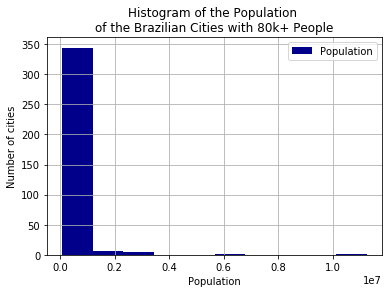

In [195]:
Cities_df[['Population']].plot (kind='hist',align='mid',color='darkblue')
plt.title('Histogram of the Population \nof the Brazilian Cities with 80k+ People')
plt.ylabel('Number of cities')
plt.xlabel('Population')
plt.grid(True)
plt.show

#### In the  population histogram, we can see that there is a strong concentration of cities between 80,000 and 1,000,000 people, and just a few cities with a population bigger than 2,000,000. 

<function matplotlib.pyplot.show(*args, **kw)>

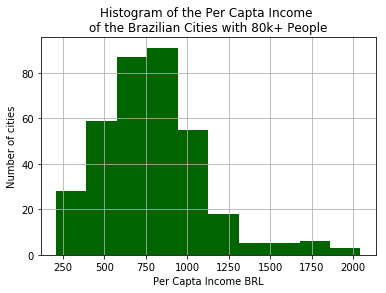

In [196]:
Cities_df['Per_capta_income'].plot (kind='hist',align='mid',color='darkgreen')
plt.title('Histogram of the Per Capta Income \nof the Brazilian Cities with 80k+ People')
plt.ylabel('Number of cities')
plt.xlabel('Per Capta Income BRL')
plt.grid(True)
plt.show

#### We can see, in the per capta income histogram above, that seems to follow a normal distribution around the averege. Although, there is a few cities with a per capta income of more than BRL 1,250. This could be seen as a social inequality indicative, but getting a better understanding about this indicative requires a deeper investigation.


<function matplotlib.pyplot.show(*args, **kw)>

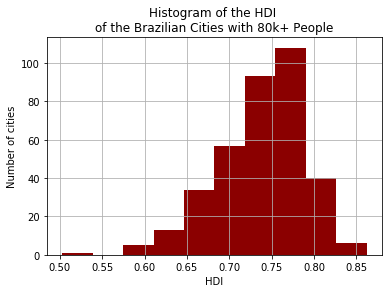

In [197]:
Cities_df['HDI'].plot (kind='hist', align='mid',color='darkred')
plt.title('Histogram of the HDI \nof the Brazilian Cities with 80k+ People')
plt.ylabel('Number of cities')
plt.xlabel('HDI')
plt.grid(True)
plt.show

#### The HDI histogram shows us that there seems to be more cities below the average than above,once we have a kind of tail gronwing from the left of the plot. Something interesting to note, is that in the same set of cities, from the same country, can be found cities with an HDI similar to very developed countries (more than 0,8 in  0 to 1 scale that comes from) and cities with HDI similar to very poor countries (around 0,5). Again, it could be seen as a social inequality indicative, but getting a better understanding about this indicative requires a deeper investigation.

#### We can also plot the Cities in maps, according to their Population, Per Capta Income an HDI. In the following maps, the size of the bubbles are proportional to the feature that is being visualized.

### Map according to the Population

In [15]:
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_brazil= folium.Map(location=[map_lat,map_long], zoom_start=4.3)
Pop_norm= Cities_df['Population']/Cities_df['Population'].max()
for i in range(Cities_df.shape[0]):
    label='{}, Population: {}'.format(Cities_df.at[i,'City'], Cities_df.at[i,'Population'])
    lat=Cities_df.at[i, 'Latitude']
    long=Cities_df.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                       radius=Pop_norm[i]*40,
                       popup=label,
                       color='darkblue',
                       weight=0.3,
                       fill=True,
                       fill_colour='darkblue',
                       fill_opacity=0.5
                       ).add_to(map_brazil)
map_brazil 

#### The map above show us clearly that in terms of population is completely an outlier with its population of more than 11,000,000 people. And also, it there seems to be more big cities in the South an Southeast regions. It's possible to see that the Brazilian big cities tend to be more densely concentrated near the seam than in the interior of the country. It's is an interesting reflex of the historical process of Brazil's colonization and expansion.

### Map according to the Per Capita Income 

In [202]:
#Mapa de Bolha da Renda 
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_brazil= folium.Map(location=[map_lat,map_long], zoom_start=4.3)
Incm_norm= Cities_df['Per_capta_income']/Cities_df['Per_capta_income'].max()

for i in range(Cities_df.shape[0]):
    label='{}, Per capita income: {}'.format(Cities_df.at[i,'City'], Cities_df.at[i,'Per_capta_income'])
    lat=Cities_df.at[i, 'Latitude']
    long=Cities_df.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=Incm_norm[i]*15,
                        popup=label,
                        color='darkgreen',
                        weight=0.3,
                        fill=True,
                        fill_colour='darkgreen',
                        fill_opacity=0.3
                        ).add_to(map_brazil)
map_brazil 

#### Similar to wat we see in the population map, here there also is a tendence to have more and bigger bubbles as we go down south in the Brazil. The region around São Paulo seems to be particularly good in terms of Per Capita Income. 

### Map according to the HDI

In [17]:
#Mapa de Bolha do HDI 
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_brazil= folium.Map(location=[map_lat,map_long], zoom_start=4.3)
HDI_norm= Cities_df['HDI']/Cities_df['HDI'].max()

for i in range(Cities_df.shape[0]):
    label='{}, HDI: {}'.format(Cities_df.at[i,'City'], Cities_df.at[i,'HDI'])
    lat=Cities_df.at[i, 'Latitude']
    long=Cities_df.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=HDI_norm[i]*5,
                        popup=label,
                        weight=0.3,
                        color='darkred',
                        fill=True,
                        fill_colour='darkred',
                        fill_opacity=0.3
                        ).add_to(map_brazil)
map_brazil 

#### At a glance, we don't actually see a great size difference between the bubbles on the above map, besides the map be more densely bubbled as we go down south. However, it seems  to be just a consequence of the fact that there are more big cities as we go down south. 
#### Perhaps, we can have a better understanding if we consider that a HDI bellow 0.550 is considered low, a HDI between 0.550 and 0.699 is considered medium, a HDI between 0.700 and 0.800 is considered high and a HDI above 0.800 is considered very high. Lets change our map a little bit in order attribute colors for each of this levels, and lets see what happens.

In [210]:
#Mapa de Bolha do HDI 
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_brazil= folium.Map(location=[map_lat,map_long], zoom_start=4.3)
HDI_norm= Cities_df['HDI']/Cities_df['HDI'].max()
colours=['red','orange','green','blue']

for i in range(Cities_df.shape[0]):
    label='{}, HDI: {}'.format(Cities_df.at[i,'City'], Cities_df.at[i,'HDI'])
    lat=Cities_df.at[i, 'Latitude']
    long=Cities_df.at[i, 'Longitude']
    hdi=Cities_df.at[i,'HDI']
    
    if (hdi<0.55):
        colour=colours[0]
    elif (hdi>0.551)&(hdi<0.699):
        colour=colours[1]
    elif (hdi>0.700)&(hdi<0.800):
        colour=colours[2]
    elif (hdi>0.800):
        colour=colours[3]       
    
    folium.CircleMarker([lat,long],
                        radius=HDI_norm[i]*5,
                        popup=label,
                        weight=0.3,
                        color=colour,
                        fill=True,
                        fill_colour=colour,
                        fill_opacity=0.3
                        ).add_to(map_brazil)
map_brazil 


#### In the map above, the yellow and orange bubbles represent those cities with a HDI low or medium, respectively.The green an blue bubbles represents the cities with an HDI considered high or very high, respectively. Therefore, now we can see a very geographically defined difference between those cities in the North and Northeast regions and those cities in the South and Southeast regions, with the first ones experimenting a worse life quality.  It's interesting to note that in a set of cities from the very same country, we have HDI levels similar to Canada or mid Africa, depending almost just on the region we are. Once more, it could be seen as a social inequality indicative, but getting a better understanding about this indicative requires a deeper investigation.

#### Going a bit further, it's interesting to notice that, especially in the Northeast region, there still are some cities with a HDI considered high. This fact is goes against what uses to be a common sense for Brazilians from South and Southwest, were is common to think about Northeast as a completely poor region. Our numbers shows that they are wrong. 

###  Consulting the Foursquare API

#### Now we are going to use the Foursquare AP explore function  in order to create a picture of each city economics. As the limit of venues that he API returns per request is 100, this picture is going to be a sample.

#### First, we create a function that gets the necessary information in order to make a request to the API: credentials, API version, latitude, longitude, limit of venues and radius of search:

In [18]:
## defining a function that gets the venues
def get_venues(client_id, client_secret, version, limit, radius, latitude, longitude,city):  
    
    #creates the request url using the information given when the function is called
    url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
    client_id, 
    client_secret, 
    version, 
    latitude, 
    longitude, 
    radius, 
    limit) 
     
    #makes the request to the Foursquare API
    results=requests.get(url).json()
    results_list = results['response']['groups'][0]['items']
    
    #Cleans the results JSON and sets the lists of names and categories of the vanues
    venue_list=[]
    category_list=[]
    for i in range(len(results_list)):
        venue_list.append(results_list[i]['venue']['name'])
        category_list.append(results_list[i]['venue']['categories'][0]['name'])
    
    #Creates a DataFrame 
    df=pd.DataFrame(columns=['City','Venue','Category'])
    df['Venue']=venue_list
    df['Category']=category_list
    df['City']=city
    
    return df

#### Then we define our credentials and API version, after that we use the function we build to loop through the cities and get their venues.

In [19]:
# Defining the credentials and the API version 
credentials_df=pd.read_csv('Credentials_df.csv')
client_id=credentials_df.at[0,'client'] 
client_secret=credentials_df.at[0,'secret']  
version='20180605'

In [20]:
#Looping trough the cities and getting their venues

#Creates a empty DataFram to be populated with the results
venues_df = pd.DataFrame(columns=['City','Venue','Category'])

#Looping
limit=100
radius=20000  
for i in range(Cities_df.shape[0]):
    longitude=Cities_df.at[i,'Longitude']
    latitude=Cities_df.at[i,'Latitude']
    city=Cities_df.at[i,'City']
    try:
        results=get_venues(client_id, client_secret, version, limit, radius, latitude, longitude,city)
        venues_df= venues_df.append(results, ignore_index=True)
    except:
        print(i, city, radius, 'not found')
venues_df.head()

,City,Venue,Category
0,ARIQUEMES,Mr. Mário's Bistro,Beer Garden
1,ARIQUEMES,Ancoradouro,Seafood Restaurant
2,ARIQUEMES,Boteco do Zé,Dive Bar
3,ARIQUEMES,Pim Pão,Bakery
4,ARIQUEMES,Subway,Sandwich Place


#### The result is the venues_df DataFrame shown above. It has three columns, 'City', ' Venue' and 'Category',  and each line represents one venue. 

#### Lets take a closer look at venues_df:

In [212]:
venues_df.describe(include='all')

,City,Venue,Category
count,30407,30407,30407
unique,357,19191,429
top,LEME,Subway,Brazilian Restaurant
freq,100,276,1554


#### Our request has resulted in 19,191 different venues in 429 categories. The most common category is 'Brazilian Restaurant', with 1554 occurrences found.

#### Our next step, is to apply the one hot encode method in the Category column, in order to get a numerical representation of this information

In [21]:
#Using one hot enconding method to get dummies categories for venues categories
venues_with_dummies=pd.get_dummies(venues_df,columns=['Category'])
venues_with_dummies.head()

,City,Venue,Category_Acai House,Category_Accessories Store,Category_Adult Boutique,Category_African Restaurant,Category_Airport,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,...,Category_Waterfall,Category_Waterfront,Category_Whisky Bar,Category_Wine Bar,Category_Wine Shop,Category_Winery,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Category_Zoo
0,ARIQUEMES,Mr. Mário's Bistro,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ARIQUEMES,Ancoradouro,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ARIQUEMES,Boteco do Zé,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,ARIQUEMES,Pim Pão,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,ARIQUEMES,Subway,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Once we have the dummies columns, we can now group the venue_df by city, applying the mean function, in order to get a frequency of occurrence of each category in each city:

In [22]:
#Grouping by the city name and gatting the ocurrency freqeunce of each kind of venue
Venues_grouped=venues_with_dummies.groupby(['City'],as_index=False).mean()
Venues_grouped.head()

,City,Category_Acai House,Category_Accessories Store,Category_Adult Boutique,Category_African Restaurant,Category_Airport,Category_Airport Lounge,Category_Airport Service,Category_Airport Terminal,Category_American Restaurant,...,Category_Waterfall,Category_Waterfront,Category_Whisky Bar,Category_Wine Bar,Category_Wine Shop,Category_Winery,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Category_Zoo
0,ABAETETUBA,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ABREU E LIMA,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ALAGOINHAS,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,ALMIRANTE TAMANDARÉ,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,ALTAMIRA,0.0,0.0,0.0,0.0,0.017857,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Merging the demographic and foursquare data

#### Here we are going to merge the result of the grouping with the Citie_df, this way, we have the frequency on occurrence of each venue and also the demographic information of the cities in the same DataFrame

In [23]:
#Merging the 'Venues_grouped' with the 'Cities_df'
Cities_with_venues=pd.merge(Cities_df,Venues_grouped, on='City')
Cities_with_venues.head()

,City_ID,City,Area,State,Population,Per_capita_income,HDI,Latitude,Longitude,Category_Acai House,...,Category_Waterfall,Category_Waterfront,Category_Whisky Bar,Category_Wine Bar,Category_Wine Shop,Category_Winery,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Category_Zoo
0,1100023,ARIQUEMES,4426.56,Rondônia,90353,689.95,0.702,-9.91359,-63.04311,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1100122,JI-PARANÁ,6896.78,Rondônia,116610,743.35,0.714,-10.87483,-61.95587,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1100205,PORTO VELHO,34082.4,Rondônia,428527,929.19,0.736,-8.76167,-63.90199,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1200401,RIO BRANCO,9222.58,Acre,336038,744.67,0.727,-9.97388,-67.80756,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1301902,ITACOATIARA,8891.99,Amazonas,86839,373.71,0.644,-3.14206,-58.44083,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### K-means Clustering

#### Once we have the all the information we want in a DataFrame, we can move on and proceed the clustering using the K-means algorithm. In order to do this, the two first thing we are going to do is drop all the irrelevant information for the algorithm, and then normalize and standardize the data that will feed the model

In [24]:
# Data normalization usin StandartScaler 
from sklearn.preprocessing import StandardScaler ## Esse cara tem que ser alimentado com um np.array

#dropping the non numerical columns from our data frame
Input_df = Cities_with_venues.drop(columns=['City_ID',
                                            'City',
                                            'Area',
                                            'State',
                                            'Population',
                                            'Latitude',
                                            'Longitude'])
Input_df.head()

#getting an Numpy array from the data
X=Input_df.values
X

#proceeding the Stadarization 
Clusterization_data=StandardScaler().fit_transform(X)
Clusterization_data

array([[-0.33308661, -0.70314268, -0.54840437, ..., -0.14567954,
        -0.17223895, -0.22910128],
       [-0.15939755, -0.47249465, -0.54840437, ..., -0.14567954,
        -0.17223895, -0.22910128],
       [ 0.44506639, -0.04963993, -0.54840437, ..., -0.14567954,
        -0.17223895, -0.22910128],
       ...,
       [-0.76028364, -0.76080468, -0.54840437, ..., -0.14567954,
        -0.17223895, -0.22910128],
       [-0.08985688,  0.14256675,  0.68531256, ..., -0.14567954,
        -0.17223895, -0.22910128],
       [ 3.00135302,  1.64177893,  1.62293743, ..., -0.14567954,
        -0.17223895, -0.22910128]])

#### The next issue that we have to deal, is to find the best K. It's is basically to determine how many centroids our model is going to have. To do this, we are going to use the elbow method. This consists in running the model several times, incrementing the K and measuring the mean squared distance of each point, to its centroid. Then we plot a graph of K and this error measure, and chose the K in which the graph 'bends' .

In [ ]:
#Finding the best k by the elbow method
error_list=[]
k_list=[]

k=5
test_limit=20
for i in range(test_limit):
   kmeans=KMeans(n_clusters=k, random_state=0).fit(X)
   error=kmeans.inertia_
   k_list.append(k)
   error_list.append(error)
   k+=1

Error_df=pd.DataFrame(columns=['Error','K'])
Error_df['Error']=error_list
Error_df['K']=k_list
Error_df.set_index('K', inplace=True)

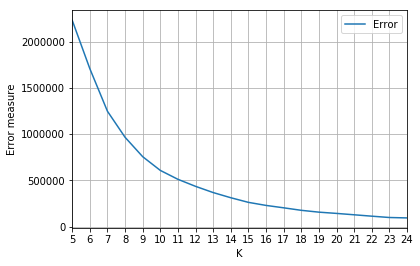

In [227]:
Error_df.plot(kind='line',xticks=k_list)
plt.ylabel('Error measure')
plt.grid(True)

#### According to the graph above, the best K is 10. So, lets use K=10 to make our model and get the vector of clusters labels:

In [27]:
k=10
kmeans=KMeans(n_clusters=k, random_state=0).fit(X)
kmeans.labels_

array([3, 3, 0, 3, 5, 5, 6, 5, 6, 5, 1, 8, 1, 6, 5, 5, 5, 1, 1, 1, 5, 1,
       8, 1, 1, 8, 3, 1, 3, 4, 1, 5, 1, 5, 5, 5, 8, 1, 1, 6, 5, 1, 3, 5,
       1, 6, 1, 5, 1, 5, 5, 5, 1, 6, 8, 0, 5, 5, 8, 0, 1, 5, 5, 1, 1, 8,
       1, 5, 5, 8, 8, 1, 8, 4, 1, 5, 5, 1, 6, 4, 1, 5, 5, 8, 8, 8, 1, 8,
       3, 8, 8, 1, 1, 4, 8, 1, 0, 8, 1, 8, 5, 8, 6, 6, 6, 7, 3, 8, 6, 6,
       3, 6, 3, 1, 6, 3, 0, 6, 6, 4, 6, 8, 3, 2, 8, 3, 6, 6, 3, 0, 6, 1,
       8, 8, 3, 6, 8, 6, 3, 0, 0, 0, 8, 3, 3, 8, 6, 6, 3, 3, 3, 9, 2, 6,
       3, 3, 3, 1, 6, 3, 8, 8, 8, 3, 1, 4, 8, 0, 8, 3, 2, 6, 8, 0, 1, 0,
       4, 7, 3, 8, 3, 6, 0, 9, 4, 4, 0, 0, 4, 6, 0, 4, 9, 6, 4, 0, 6, 6,
       7, 3, 3, 0, 4, 3, 3, 8, 8, 6, 1, 8, 0, 3, 6, 3, 4, 3, 8, 3, 8, 8,
       1, 4, 4, 6, 6, 0, 7, 3, 0, 6, 0, 0, 3, 0, 6, 0, 0, 6, 9, 6, 4, 3,
       6, 4, 6, 9, 4, 6, 6, 2, 9, 2, 9, 2, 4, 0, 9, 9, 7, 6, 0, 4, 6, 8,
       6, 3, 0, 7, 3, 3, 0, 8, 6, 6, 6, 3, 3, 6, 0, 3, 7, 3, 6, 3, 4, 9,
       3, 6, 0, 8, 6, 6, 8, 6, 6, 7, 9, 4, 4, 4, 2,

#### After getting the cluster labels array, we can put is as a column in our DataFrame that gathers the information we have about our cities: 

In [103]:
Cities_with_venues['Cluster']=kmeans.labels_
Cities_with_venues.head()

,City_ID,City,Area,State,Population,Per_capita_income,HDI,Latitude,Longitude,Category_Acai House,...,Category_Waterfront,Category_Whisky Bar,Category_Wine Bar,Category_Wine Shop,Category_Winery,Category_Wings Joint,Category_Women's Store,Category_Yoga Studio,Category_Zoo,Cluster
0,1100023,ARIQUEMES,4426.56,Rondônia,90353,689.95,0.702,-9.91359,-63.04311,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
1,1100122,JI-PARANÁ,6896.78,Rondônia,116610,743.35,0.714,-10.87483,-61.95587,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
2,1100205,PORTO VELHO,34082.4,Rondônia,428527,929.19,0.736,-8.76167,-63.90199,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,1200401,RIO BRANCO,9222.58,Acre,336038,744.67,0.727,-9.97388,-67.80756,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3
4,1301902,ITACOATIARA,8891.99,Amazonas,86839,373.71,0.644,-3.14206,-58.44083,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


#### To make our understanding easier, lets create a DataFrame to show us the 10 most common venue categories for each city:

In [29]:
#To make our understanding easier, lets create a DataFrame to show us the 10 most common venue categories

Cities_venues=Cities_with_venues.drop(columns=['City_ID',
                                                 'Area',
                                                 'HDI',
                                                 'Per_capita_income',
                                                 'State','Population',
                                                 'Latitude',
                                                 'Longitude',
                                                 'Cluster'])

limit=10
ranking_list=[]
for i in range (Cities_with_venues.shape[0]):
   
    freq=Cities_venues.iloc[i].T
    freq=freq.reset_index()

    temp=pd.DataFrame(columns=['City','Category','Frequency'])
    temp['Category']=freq.iloc[:,0]
    temp['Frequency']=freq.iloc[:,1]
    temp['City']=Cities_with_venues.loc[i,'City']
    temp=temp.drop(index=0,axis=0)


    ranking_df=temp.sort_values(by='Frequency', ascending=False).reset_index(drop=True)
    ranking_df    
    ranking_df=ranking_df.iloc[0:limit,:]
    ranking_df
    ranking_list.append(ranking_df)

In [30]:
#Creates a DataFrame with comlumns for the 10 most Common Categories for each City
most_commons_df=pd.DataFrame()
most_commons_df['City']=Cities_venues['City']

for rank in range(limit):
    list_of_most_common=[]
    if rank==0:
        for i in range(Cities_venues.shape[0]):
            temp=ranking_list[i]
            most_common=temp.loc[rank,'Category']
            list_of_most_common.append(most_common)
            format='{}st_most_common'.format(rank+1)
            df= pd.DataFrame()
            df[format]=list_of_most_common
        most_commons_df=pd.concat([most_commons_df,df],axis=1)  
    
    elif rank==1:
        for i in range(Cities_venues.shape[0]):
            temp=ranking_list[i]
            most_common=temp.loc[rank,'Category']
            list_of_most_common.append(most_common)
            format='{}nd_most_common'.format(rank+1)
            df= pd.DataFrame()
            df[format]=list_of_most_common
        most_commons_df=pd.concat([most_commons_df,df],axis=1)  
    
    elif rank==2:
        for i in range(Cities_venues.shape[0]):
            temp=ranking_list[i]
            most_common=temp.loc[rank,'Category']
            list_of_most_common.append(most_common)
            format='{}rd_most_common'.format(rank+1)
            df= pd.DataFrame()
            df[format]=list_of_most_common
        most_commons_df=pd.concat([most_commons_df,df],axis=1)    
    
    else:
        for i in range(Cities_venues.shape[0]):
            temp=ranking_list[i]
            most_common=temp.loc[rank,'Category']
            list_of_most_common.append(most_common)
            format='{}th_most_common'.format(rank+1)
            df= pd.DataFrame()
            df[format]=list_of_most_common
        most_commons_df=pd.concat([most_commons_df,df],axis=1)

most_commons_df.head()

,City,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
0,ARIQUEMES,Category_Hotel,Category_Ice Cream Shop,Category_Supermarket,Category_Pizza Place,Category_Gym / Fitness Center,Category_Bakery,Category_Restaurant,Category_Shopping Mall,Category_Brewery,Category_Multiplex
1,JI-PARANÁ,Category_Pizza Place,Category_Brazilian Restaurant,Category_Gym / Fitness Center,Category_Ice Cream Shop,Category_BBQ Joint,Category_Bakery,Category_Pub,Category_Japanese Restaurant,Category_Supermarket,Category_Movie Theater
2,PORTO VELHO,Category_Brazilian Restaurant,Category_Bar,Category_Restaurant,Category_Gym,Category_Snack Place,Category_Japanese Restaurant,Category_Hotel,Category_Sandwich Place,Category_Gym / Fitness Center,Category_Dessert Shop
3,RIO BRANCO,Category_Brazilian Restaurant,Category_Ice Cream Shop,Category_BBQ Joint,Category_Snack Place,Category_Hotel,Category_Gym / Fitness Center,Category_Gym,Category_Park,Category_Bakery,Category_Burger Joint
4,ITACOATIARA,Category_Brazilian Restaurant,Category_Burger Joint,Category_Bakery,Category_Grocery Store,Category_BBQ Joint,Category_Northern Brazilian Restaurant,Category_Pizza Place,Category_Arts & Entertainment,Category_Fast Food Restaurant,Category_Gym / Fitness Center


#### Lets merge the information we want in a single DataFrame, which has the demograpich information, the clusters labels and the 10 most common venues category for each city: 

In [43]:
Cities=Cities_with_venues[['City','Population','HDI','Per_capita_income','State','Latitude','Longitude','Cluster']]
Cities=pd.merge(Cities,most_commons_df, on='City')
Cities.head()

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
0,ARIQUEMES,90353,0.702,689.95,Rondônia,-9.91359,-63.04311,3,Category_Hotel,Category_Ice Cream Shop,Category_Supermarket,Category_Pizza Place,Category_Gym / Fitness Center,Category_Bakery,Category_Restaurant,Category_Shopping Mall,Category_Brewery,Category_Multiplex
1,JI-PARANÁ,116610,0.714,743.35,Rondônia,-10.87483,-61.95587,3,Category_Pizza Place,Category_Brazilian Restaurant,Category_Gym / Fitness Center,Category_Ice Cream Shop,Category_BBQ Joint,Category_Bakery,Category_Pub,Category_Japanese Restaurant,Category_Supermarket,Category_Movie Theater
2,PORTO VELHO,428527,0.736,929.19,Rondônia,-8.76167,-63.90199,0,Category_Brazilian Restaurant,Category_Bar,Category_Restaurant,Category_Gym,Category_Snack Place,Category_Japanese Restaurant,Category_Hotel,Category_Sandwich Place,Category_Gym / Fitness Center,Category_Dessert Shop
3,RIO BRANCO,336038,0.727,744.67,Acre,-9.97388,-67.80756,3,Category_Brazilian Restaurant,Category_Ice Cream Shop,Category_BBQ Joint,Category_Snack Place,Category_Hotel,Category_Gym / Fitness Center,Category_Gym,Category_Park,Category_Bakery,Category_Burger Joint
4,ITACOATIARA,86839,0.644,373.71,Amazonas,-3.14206,-58.44083,5,Category_Brazilian Restaurant,Category_Burger Joint,Category_Bakery,Category_Grocery Store,Category_BBQ Joint,Category_Northern Brazilian Restaurant,Category_Pizza Place,Category_Arts & Entertainment,Category_Fast Food Restaurant,Category_Gym / Fitness Center


## 3 - Results

#### Now that we have already successfully ​proceeded the clusterization, we can take a closer look in each cluster:

### Cluster 0 

In [303]:
cluster=0
Cluster_0 = Cities[Cities['Cluster']==cluster]
Cluster_0.reset_index(drop=True, inplace=True)
Cluster_0.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,40,4.000000e+01,40.000000,40.000000,40,40.000000,40.000000,40.0,40,40,40,40,40,40,40,40,40,40
unique,40,NaN,NaN,NaN,11,NaN,NaN,NaN,13,14,18,21,18,23,25,26,28,28
top,LIMEIRA,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Bar,Category_Pizza Place,Category_Hotel,Category_Bakery,Category_Brazilian Restaurant,Category_Restaurant,Category_Café,Category_Burger Joint,Category_Bakery
freq,1,NaN,NaN,NaN,17,NaN,NaN,NaN,11,7,8,4,7,3,7,5,4,5
mean,NaN,2.898609e+05,0.773350,954.045000,NaN,-21.469183,-47.426634,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,4.284994e+05,0.017944,32.130775,NaN,5.310832,4.787085,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.075500e+04,0.736000,904.570000,NaN,-29.915230,-63.901990,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.115725e+05,0.760500,925.707500,NaN,-23.103647,-49.954452,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.495895e+05,0.776000,951.650000,NaN,-22.427980,-47.660655,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.886330e+05,0.787250,974.907500,NaN,-20.518260,-45.533930,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 0 has:
#### Number of cities: 40
#### Average Population:  289,860 
#### Average Per Capita Income: 954.00 BRL
#### Average HDI: 0.773 
#### The five most common venue categories are:  Brazilian Restaurant, Bar, Pizza Place, Hotel and Bakery

### Cluster 0 on the map:

In [299]:
color_list = ['navy','darkseagreen','blue','lime','royalblue','forestgreen','dodgerblue','mediumseagreen','indigo','darkblue']

In [263]:
#Cluster_0 Map

#Mapa de Bolha do HDI 
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_0= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_0.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_0.at[i,'City'], Cluster_0.at[i,'Cluster'])
    lat=Cluster_0.at[i, 'Latitude']
    long=Cluster_0.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_0)
map_cluster_0 

#### Cluster 0 seems to gather cities with not so large population and good demographic indicators, and is interesting to notice that we have cities from all geographic regions of the country. 

### Cluster 1

In [265]:
cluster=1
Cluster_1 = Cities[Cities['Cluster']==cluster]
Cluster_1.reset_index(drop=True, inplace=True)
Cluster_1.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,41,41.000000,41.000000,41.000000,41,41.000000,41.000000,41.0,41,41,41,41,41,41,41,41,41,41
unique,41,NaN,NaN,NaN,14,NaN,NaN,NaN,16,15,20,18,19,23,26,27,24,30
top,IGUATU,NaN,NaN,NaN,Pará,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Brazilian Restaurant,Category_Brazilian Restaurant,Category_Bakery,Category_BBQ Joint,Category_Restaurant,Category_Gym / Fitness Center,Category_Bar,Category_Ice Cream Shop,Category_Restaurant
freq,1,NaN,NaN,NaN,8,NaN,NaN,NaN,9,11,4,5,7,4,5,3,7,4
mean,NaN,157139.487805,0.679780,471.127561,NaN,-9.960431,-43.469794,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,83298.645744,0.025919,33.765593,NaN,7.002847,5.659945,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,81649.000000,0.594000,409.070000,NaN,-23.478720,-55.989520,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,97819.000000,0.665000,440.600000,NaN,-15.430540,-47.566300,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,129408.000000,0.684000,470.460000,NaN,-7.954430,-43.655890,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,185025.000000,0.692000,492.440000,NaN,-4.269180,-39.064770,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 1 has:
#### Number of cities: 41
#### Average Population:  157,139
#### Average Per Capita Income: 471.12 BRL
#### Average HDI: 0.471 
#### The five most common venue categories are:  Brazilian Restaurant, Bakery, BBQ Joint, Restaurant and Gym/Fitness Center

### Cluster 1 on the map:

In [266]:
#Cluster_1 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_1= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_1.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_1.at[i,'City'], Cluster_1.at[i,'Cluster'])
    lat=Cluster_1.at[i, 'Latitude']
    long=Cluster_1.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_1)
map_cluster_1 

#### Cluster 1 seems to gather cities with not so large population, but also not so good demographic indicators, many of them in the North or Northeast regions, but there are some of them in the Southeast region of the country too. 

### Cluster 2

In [268]:
cluster=2
Cluster_2 = Cities[Cities['Cluster']==cluster]
Cluster_2.reset_index(drop=True, inplace=True)
Cluster_2.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,9,9.000000e+00,9.000000,9.000000,9,9.000000,9.000000,9.0,9,9,9,9,9,9,9,9,9,9
unique,9,NaN,NaN,NaN,7,NaN,NaN,NaN,6,5,8,8,8,8,7,9,8,9
top,SANTANA DE PARNAÍBA,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Gym / Fitness Center,Category_Pizza Place,Category_Café,Category_Scenic Lookout,Category_Brazilian Restaurant,Category_Ice Cream Shop,Category_Coffee Shop,Category_Steakhouse,Category_Café,Category_Park
freq,1,NaN,NaN,NaN,3,NaN,NaN,NaN,3,3,2,2,2,2,2,1,2,1
mean,NaN,6.638431e+05,0.831889,1829.587778,NaN,-23.069064,-46.091008,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,8.189165e+05,0.018911,124.715227,NaN,4.190393,3.236744,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.099800e+04,0.805000,1693.650000,NaN,-30.033920,-51.227990,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.492630e+05,0.814000,1731.840000,NaN,-23.961440,-47.928650,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.194000e+05,0.837000,1798.120000,NaN,-23.446520,-46.572080,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,4.875620e+05,0.845000,1866.580000,NaN,-20.320620,-43.846790,2.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 2 has:
#### Number of cities: 9
#### Average Population:  663,384
#### Average Per Capita Income: 1829.59 BRL
#### Average HDI: 0.832
#### The five most common venue categories are:  Gym/Fitness Center, Pizza Place, Café, Scenic Lookout and Brazilian Restaurant

### Cluster 2 on the map:

In [269]:
#Cluster_2 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_2= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_2.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_2.at[i,'City'], Cluster_2.at[i,'Cluster'])
    lat=Cluster_2.at[i, 'Latitude']
    long=Cluster_2.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_2)
map_cluster_2 

#### Cluster 3 seems to gather some big cities as Porto Alegre and Brazília (the capital of the country) with very good demographic indicators, very similar to developed countries. Something worthy to note is that the most common venue categories indicates some very specific or sophisticated kinds of services. However, there seems just a few of this cities.  

### Cluster 3

In [271]:
cluster=3
Cluster_3 = Cities[Cities['Cluster']==cluster]
Cluster_3.reset_index(drop=True, inplace=True)
Cluster_3.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,59,59.000000,59.000000,59.000000,59,59.000000,59.000000,59.0,59,59,59,59,59,59,59,59,59,59
unique,59,NaN,NaN,NaN,14,NaN,NaN,NaN,16,17,21,26,27,28,32,32,36,33
top,VOTORANTIM,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Brazilian Restaurant,Category_Restaurant,Category_Bakery,Category_Pizza Place,Category_Brazilian Restaurant,Category_Bar,Category_Gym / Fitness Center,Category_Gym,Category_Burger Joint
freq,1,NaN,NaN,NaN,14,NaN,NaN,NaN,10,12,9,10,7,8,4,5,5,8
mean,NaN,206812.152542,0.738729,716.185254,NaN,-20.980173,-47.179786,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,179758.331730,0.015854,32.236990,NaN,6.083897,5.726075,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,81675.000000,0.702000,660.560000,NaN,-30.889680,-67.807560,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,100425.000000,0.727000,689.020000,NaN,-23.676615,-49.281855,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,125435.000000,0.737000,711.380000,NaN,-22.541320,-46.789350,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,254128.000000,0.751500,744.640000,NaN,-19.458390,-42.992760,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 3 has:
#### Number of cities: 59
#### Average Population:  206,812
#### Average Per Capita Income: 716.18 BRL
#### Average HDI: 0.738
#### The five most common venue categories are:  Brazilian Restaurant, Restaurant, Bakery, Pizza Place and Bar

### Cluster 3 on the map

In [273]:
#Cluster_3 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_3= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_3.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_3.at[i,'City'], Cluster_3.at[i,'Cluster'])
    lat=Cluster_3.at[i, 'Latitude']
    long=Cluster_3.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_3)
map_cluster_3 

#### Cluster 3 seems to gather the 'average city' of Southeast region. The demographic indicators are not similar to developed countries, but neither indicate a extreme poverty situation. Here is interesting to notice that there are some cities in North and Northeast that have a similar situation to what we could call 'average life quality' of Southeast region, what goes against to what is a common sense. 

### Cluster 4 

In [275]:
cluster=4 
Cluster_4 = Cities[Cities['Cluster']==cluster]
Cluster_4.reset_index(drop=True, inplace=True)
Cluster_4.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,33,3.300000e+01,33.000000,33.000000,33,33.000000,33.000000,33.0,33,33,33,33,33,33,33,33,33,33
unique,33,NaN,NaN,NaN,11,NaN,NaN,NaN,11,14,15,18,17,21,18,25,25,24
top,PASSO FUNDO,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Bar,Category_Brazilian Restaurant,Category_Pizza Place,Category_Pizza Place,Category_Ice Cream Shop,Category_Bakery,Category_Gym / Fitness Center,Category_Café,Category_Bar
freq,1,NaN,NaN,NaN,14,NaN,NaN,NaN,6,6,8,4,4,4,6,3,4,4
mean,NaN,2.918305e+05,0.785485,1078.950909,NaN,-22.741341,-47.560104,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,2.819650e+05,0.014359,32.913351,NaN,5.334299,4.549315,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,9.608700e+04,0.754000,1017.340000,NaN,-29.925160,-54.615330,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.431230e+05,0.776000,1051.190000,NaN,-26.492470,-50.433420,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,2.011500e+05,0.785000,1080.660000,NaN,-23.087650,-48.175440,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.610310e+05,0.796000,1098.310000,NaN,-22.014620,-46.844610,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 4 has:
#### Number of cities: 33
#### Average Population:  291,830
#### Average Per Capita Income: 1078.18 BRL
#### Average HDI: 0.785
#### The five most common venue categories are:  Brazilian Restaurant, Bar, Pizza Place, Ice Cream Shop Bakery

### Cluster 4 on the Map: 

In [276]:
#Cluster_4 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_4= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_4.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_4.at[i,'City'], Cluster_4.at[i,'Cluster'])
    lat=Cluster_4.at[i, 'Latitude']
    long=Cluster_4.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_4)
map_cluster_4 


#### Cluster 4 seems to gather some big cities, with good demographic indicators, mainly Per Capita Income. Here, the much of the cities are in the Southeast an South regions, but there are some of them in the Northeast too. If you are a Brazilian reader, is kind of surprising to realize that a person who lives in Aracajú- SE experiments a life quality similar to a person who lives in Criciúma-SC, but if you check the numbers,  you will see that it makes sense. Taking a look at the most common venue categories, we can notice that the venues tends to go beyond to the basics, what indicates that the economics of this cities seems to be diversified.   

### Cluster 5

In [279]:
cluster=5
Cluster_5 = Cities[Cities['Cluster']==cluster]
Cluster_5.reset_index(drop=True, inplace=True)
Cluster_5.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,29,29.000000,29.000000,29.000000,29,29.000000,29.000000,29.0,29,29,29,29,29,29,29,29,29,29
unique,29,NaN,NaN,NaN,9,NaN,NaN,NaN,14,16,20,18,20,21,20,22,21,22
top,SÃO LOURENÇO DA MATA,NaN,NaN,NaN,Pernambuco,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Pizza Place,Category_Brazilian Restaurant,Category_Pizza Place,Category_Gym,Category_Burger Joint,Category_Bar,Category_Brazilian Restaurant,Category_Pizza Place,Category_Bar
freq,1,NaN,NaN,NaN,5,NaN,NaN,NaN,7,4,5,5,3,4,3,3,4,5
mean,NaN,119605.241379,0.636414,339.421034,NaN,-5.403547,-42.366841,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,49163.697241,0.037416,49.945542,NaN,3.095459,7.511398,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,80604.000000,0.503000,209.140000,NaN,-13.368600,-60.631340,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,92860.000000,0.623000,311.970000,NaN,-7.839160,-46.768190,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,102895.000000,0.644000,362.800000,NaN,-4.864590,-39.071490,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,120896.000000,0.659000,376.740000,NaN,-3.291240,-35.328830,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 5 has:
#### Number of cities: 29
#### Average Population:  49,163
#### Average Per Capita Income: 339.18 BRL
#### Average HDI: 0.636
#### The five most common venue categories are:  Brazilian Restaurant, Pizza Place, Gym, Burger Joint and Bar

### Cluster 5 on the Map:

In [292]:
#Cluster_5 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_5= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_5.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_5.at[i,'City'], Cluster_5.at[i,'Cluster'])
    lat=Cluster_5.at[i, 'Latitude']
    long=Cluster_5.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_5)
map_cluster_5 

#### Cluster 5 seems to gather some small cities with not so good demographic indicators, mainly Per Capita Income. A closer look at the most commons venues categories indicates that the economies of this cities don't seem to be very diversified what could be interpreted as a underdevelopment indicator.  

### Cluster 6

In [283]:
cluster=6
Cluster_6 = Cities[Cities['Cluster']==cluster]
Cluster_6.reset_index(drop=True, inplace=True)
Cluster_6.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,71,7.100000e+01,71.000000,71.000000,71,71.000000,71.000000,71.0,71,71,71,71,71,71,71,71,71,71
unique,71,NaN,NaN,NaN,17,NaN,NaN,NaN,16,16,25,25,31,29,32,32,41,36
top,Barbacena,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Pizza Place,Category_Pizza Place,Category_Pizza Place,Category_Brazilian Restaurant,Category_Restaurant,Category_Bakery,Category_Hotel,Category_Bar,Category_Burger Joint
freq,1,NaN,NaN,NaN,19,NaN,NaN,NaN,20,15,7,8,7,8,7,7,4,9
mean,NaN,2.738191e+05,0.758225,836.031127,NaN,-20.665499,-47.899448,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,4.061782e+05,0.015704,32.712824,NaN,6.851597,4.919822,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.124300e+04,0.721000,781.280000,NaN,-32.033140,-60.673560,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,1.047180e+05,0.746500,805.085000,NaN,-23.587945,-51.260765,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.372450e+05,0.760000,843.620000,NaN,-22.412390,-47.263090,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,2.403895e+05,0.769500,862.825000,NaN,-19.539365,-44.943785,6.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 6 has:
#### Number of cities: 71
#### Average Population: 273,819
#### Average Per Capita Income: 836.03 BRL
#### Average HDI: 0.758
#### The five most common venue categories are: Brazilian Restaurant, Pizza Place, Restaurant, Bakery and Hotel

### Cluster 6 on the Map:

In [284]:
#Cluster_6 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_6= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_6.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_6.at[i,'City'], Cluster_6.at[i,'Cluster'])
    lat=Cluster_6.at[i, 'Latitude']
    long=Cluster_6.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_6)
map_cluster_6 

#### Cluster 6 seems to represent what we could call the 'Average Brazilian Big City'. This cluster is very similar to Cluster 3, but here we have far more cities. The demographic indicators, again, the demographic indicators are not similar to the reach countries, but neither indicate a extreme poverty situation. However, these cities are seems to be bigger in population than the ones in Cluster_3, and  the average Per Capita Income is also bigger.   

### Cluster 7

In [293]:
cluster=7 
Cluster_7 = Cities[Cities['Cluster']==cluster]
Cluster_7.reset_index(drop=True, inplace=True)
Cluster_7.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,8,8.000000e+00,8.000000,8.00000,8,8.000000,8.000000,8.0,8,8,8,8,8,8,8,8,8,8
unique,8,NaN,NaN,NaN,5,NaN,NaN,NaN,5,7,8,5,6,5,6,7,8,7
top,VALINHOS,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Bar,Category_Pizza Place,Category_Steakhouse,Category_Pizza Place,Category_Italian Restaurant,Category_Brazilian Restaurant,Category_Restaurant,Category_Coffee Shop,Category_Hotel,Category_Ice Cream Shop
freq,1,NaN,NaN,NaN,4,NaN,NaN,NaN,3,2,1,4,2,3,3,2,1,2
mean,NaN,2.920766e+06,0.816000,1513.25625,NaN,-23.486434,-46.579746,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.934819e+06,0.014648,78.27666,NaN,2.065083,2.090312,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,1.067930e+05,0.799000,1390.83000,NaN,-26.991600,-49.276540,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,3.046168e+05,0.805000,1477.36000,NaN,-24.032147,-47.457447,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,1.416010e+06,0.814500,1506.75000,NaN,-23.078160,-46.946410,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,3.361475e+06,0.822250,1573.44250,NaN,-22.911375,-45.975592,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 7 has:
#### Number of cities: 8
#### Average Population: 2,920,766
#### Average Per Capita Income: 1513.25 BRL
#### Average HDI: 0.816
#### The five most common venue categories are: Bar, Pizza Place, Stake House, Italian Restaurant, Restaurant

### Cluster 7 on the map:

In [289]:
#Cluster_7 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_7= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_7.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_7.at[i,'City'], Cluster_7.at[i,'Cluster'])
    lat=Cluster_7.at[i, 'Latitude']
    long=Cluster_7.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_7)
map_cluster_7 

#### Cluster 7 seems to gather some big cities with very good demographic indicator. There are four state capitals among them: São Paulo, Rio de Janeiro, Belo Horizonte an Curitiba. Similar to what happened in Cluster 2, here we also can see  demographic indicators that are similar to developed countries, but what make this two clusters different, probably are the populations sizes, what in cluster 3 tend to be quite bigger. The most common venue categories here shows some diversification, what can be read as a economic development indicator. The presence of  Valinhos, a little city in the interior of São Paulo State, is very interesting. What this little city has to do among these big metropolis? Probably the number of Bars. It requires further investigation.  

### Cluster 8

In [295]:
cluster=8
Cluster_8 = Cities[Cities['Cluster']==cluster]
Cluster_8.reset_index(drop=True, inplace=True)
Cluster_8.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,51,51.000000,51.000000,51.000000,51,51.000000,51.000000,51.0,51,51,51,51,51,51,51,51,51,51
unique,51,NaN,NaN,NaN,15,NaN,NaN,NaN,16,20,23,18,20,26,32,27,30,32
top,EUNÁPOLIS,NaN,NaN,NaN,Bahia,NaN,NaN,NaN,Category_Pizza Place,Category_Brazilian Restaurant,Category_Restaurant,Category_Pizza Place,Category_Brazilian Restaurant,Category_Ice Cream Shop,Category_Restaurant,Category_Restaurant,Category_Burger Joint,Category_Restaurant
freq,1,NaN,NaN,NaN,10,NaN,NaN,NaN,9,9,7,8,6,6,4,5,6,5
mean,NaN,224676.803922,0.710980,594.040000,NaN,-16.970732,-44.203616,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,171052.428611,0.022431,34.037902,NaN,6.771211,5.245261,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,82847.000000,0.666000,534.020000,NaN,-30.000570,-57.658000,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,104507.500000,0.698000,562.745000,NaN,-22.794535,-47.708930,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,168376.000000,0.711000,593.900000,NaN,-17.541020,-43.810900,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,261147.500000,0.726000,621.830000,NaN,-12.420720,-40.050380,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 8 has:
#### Number of cities: 51
#### Average Population: 171,052
#### Average Per Capita Income: 594.25 BRL
#### Average HDI: 0.710
#### The five most common venue categories are:Pizza Place,Brazilian Restaurant,Restaurant, Ice Cream Shop and Burguer Joint

### Cluster 8 on the map

In [294]:
#Cluster_8 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_8= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_4.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_8.at[i,'City'], Cluster_8.at[i,'Cluster'])
    lat=Cluster_8.at[i, 'Latitude']
    long=Cluster_8.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_8)
map_cluster_8 

#### Cluster 8 seems to represent what we could call the 'Average Brazilian Northeast Big City'. The fact that the most common State in this Cluster is Bahia, indicates that. Here, the demographic indicators don't seem to reveal a extreme poverty situation, although the Per Capita Income is smaller than seen in other clusters. Here, it's interesting to notice the presence of cities in Minas Gerais and Rio de Janeiro in the same cluster of cities in Northeast, what goes against the common sense. Here, we also can't see to much diversification in the most common venue categories what can be seen as an underdevelopment indicator .

### Cluster 9

In [300]:
cluster=9
Cluster_9 = Cities[Cities['Cluster']==cluster]
Cluster_9.reset_index(drop=True, inplace=True)
Cluster_9.describe(include='all')

,City,Population,HDI,Per_capita_income,State,Latitude,Longitude,Cluster,1st_most_common,2nd_most_common,3rd_most_common,4th_most_common,5th_most_common,6th_most_common,7th_most_common,8th_most_common,9th_most_common,10th_most_common
count,16,1.600000e+01,16.000000,16.000000,16,16.000000,16.000000,16.0,16,16,16,16,16,16,16,16,16,16
unique,16,NaN,NaN,NaN,7,NaN,NaN,NaN,7,10,12,10,13,11,14,13,13,14
top,AMERICANA,NaN,NaN,NaN,São Paulo,NaN,NaN,NaN,Category_Brazilian Restaurant,Category_Pizza Place,Category_Bakery,Category_Park,Category_Bar,Category_Brazilian Restaurant,Category_Bar,Category_Hotel,Category_Middle Eastern Restaurant,Category_Fruit & Vegetable Store
freq,1,NaN,NaN,NaN,8,NaN,NaN,NaN,4,4,3,3,3,2,2,3,2,2
mean,NaN,4.629919e+05,0.799875,1216.437500,NaN,-23.297098,-48.696462,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,3.001368e+05,0.010551,61.276971,NaN,4.264213,3.453223,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,NaN,8.214600e+04,0.778000,1157.430000,NaN,-32.034100,-56.094640,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
25%,NaN,2.844178e+05,0.796500,1163.315000,NaN,-24.506807,-49.918950,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
50%,NaN,4.114220e+05,0.800500,1199.595000,NaN,-22.971735,-49.068230,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
75%,NaN,6.109918e+05,0.807250,1253.360000,NaN,-21.085212,-47.001480,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


#### The table above shows us that Cluster 8 has:
#### Number of cities: 16
#### Average Population: 462,991
#### Average Per Capita Income: 1216.43 BRL
#### Average HDI: 0.799
#### The five most common venue categories are:Brazilian Restaurant, Pizza Place, Bakery, Park and Bar

### Cluster 9 on the Map

In [301]:
#Cluster_9 map
map_lat = float(Cities_df[['Latitude']].mean())
map_long= float(Cities_df[['Longitude']].mean())
map_cluster_9= folium.Map(location=[map_lat,map_long], zoom_start=4.3)

for i in range(Cluster_9.shape[0]):
    label='{}, Cluster: {}'.format(Cluster_9.at[i,'City'], Cluster_9.at[i,'Cluster'])
    lat=Cluster_9.at[i, 'Latitude']
    long=Cluster_9.at[i, 'Longitude']
    folium.CircleMarker([lat,long],
                        radius=5,
                        popup=label,
                        weight=0.3,
                        color=color_list[cluster],
                        fill=True,
                        fill_colour=color_list[cluster],
                        fill_opacity=0.7
                        ).add_to(map_cluster_9)
map_cluster_9 

####  Cluster 9 can be seen as a 'second level' of Cluster 7. Here we also have some big cities with nice demographic indicators, including two state capitals, Goiânia and Cuiabá. But the avarege population of this  is quite smaller. The most commons venue categories indicates some economic diversity too, and something that comes to our attention is the presence of  Parks as a common category, this can indicate that these cities tend to be greener that the ones in Cluster 7. 

## 4 - Discussion 

 ####    We can say that our analysis revealed some interesting insights about how the biggest cities in Brazil can be grouped based on Data. It was possible to see that cities in different regions over the country share similarities that don't are seen as a common sense. In Brasil, still there is some kind of prejudice, based just only on the region that a person lives or comes from. But a closer look at some data using a machine learning approach, can reveal that, people from what is used to be seen as completely different, cities actually share a very similar life quality. Besides that, the analysis of the clusters also revealed what could be called as being a 'cruel' face of this beautiful country, as seen, we got clusters were the numbers show similarities to developed countries, but in the other hand, in the same country we also got clusters which numbers show  similarities to very poor countries. Finally, the samples of venues that we got from the foursquare API helped to build a more complete picture of each city, playing a important part in creating good clusters.

## 5 - Conclusion and future directions

####  The main conclusion we can get from our analysis is that Brazilian big cities are diverse in more ways than just the geographic common sense tends to judges. The clusters that we get, could be use as a star point for deeper investigations, or to star a knowledge exchange process between the cities from the same country. They can also point business opportunities that use to be hidden behind the countries distances. If you are a leader in a company that operates in Southeast, and this analysis shows that there are some similar cities in North or Northeast, it cloud be a good idea to start to operate there too.       


#### As further work suggestion, it would be worthy to tune the parameters of the model and compare results. For example, what would happen with the clusters if we take a lower population limit than 80,000? And what if we change the radius of search passed to the API? This questions should be considered if this model some time, for any reason, turns out to be a production solution. Besides that, in my point of view, the limits of use of the Foursquare API makes it a good solution when dealing with neighborhoods, or even small cities, perhaps. But when we talk about dealing with many cities, some of then quite big, it requires some smarter way to make our code in order to get more venues in each cities without having to build a big list of neighborhoods and  geo coordinates for each city, what could turns out in a kind of hard issue, if we think in small cities in Brazilian interior.  Finally, in terms of coding, it should be much easier to create a function to deal with making maps, but when I realized it, the model were almost finished and the code was working just well. Perhaps, in a 2.0 version of this analysis we take this approach.  

### Thanks for reading!